Copyright 2017 Google Inc.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


# dSprites - Disentanglement testing Sprites dataset

## Description
Procedurally generated 2D shapes dataset. This dataset uses 6 latents, controlling the color, shape, scale, rotation and position of a sprite (color isn't varying here, its value is fixed).

All possible combinations of the latents are present.

The ordering of images in the dataset (i.e. shape[0] in all ndarrays) is fixed and meaningful, see below.

We chose the smallest changes in latent values that generated different pixel outputs at our 64x64 resolution after rasterization.

No noise added, single image sample for a given latent setting.

## Details about the ordering of the dataset

The dataset was generated procedurally, and its order is deterministic.
For example, the image at index 0 corresponds to the latents (0, 0, 0, 0, 0, 0).

Then the image at index 1 increases the least significant "bit" of the latent:
(0, 0, 0, 0, 0, 1)

And similarly, till we reach index 32, where we get (0, 0, 0, 0, 1, 0). 

Hence the dataset is sequentially addressable using variable bases for every "bit".
Using dataset['metadata']['latents_sizes'] makes this conversion trivial, see below.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})


In [2]:
# Load dataset
dataset_zip = np.load('dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', allow_pickle=True, encoding='latin1')

print('Keys in the dataset:', dataset_zip.keys())
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
metadata = dataset_zip['metadata'][()]

print('Metadata: \n', metadata)


FileNotFoundError: [Errno 2] No such file or directory: 'dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'

In [ ]:
# Define number of values per latents and functions to convert to indices
latents_sizes = metadata['latents_sizes']
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

def latent_to_index(latents):
  return np.dot(latents, latents_bases).astype(int)


def sample_latent(size=1):
  samples = np.zeros((size, latents_sizes.size))
  for lat_i, lat_size in enumerate(latents_sizes):
    samples[:, lat_i] = np.random.randint(lat_size, size=size)

  return samples


In [ ]:
# Helper function to show images
def show_images_grid(imgs_, num_images=25):
  ncols = int(np.ceil(num_images**0.5))
  nrows = int(np.ceil(num_images / ncols))
  _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
  axes = axes.flatten()

  for ax_i, ax in enumerate(axes):
    if ax_i < num_images:
      ax.imshow(imgs_[ax_i], cmap='Greys_r',  interpolation='nearest')
      ax.set_xticks([])
      ax.set_yticks([])
    else:
      ax.axis('off')

def show_density(imgs):
  _, ax = plt.subplots()
  ax.imshow(imgs.mean(axis=0), interpolation='nearest', cmap='Greys_r')
  ax.grid('off')
  ax.set_xticks([])
  ax.set_yticks([])

In [ ]:
## Fix posX latent to left
latents_sampled_dx = sample_latent(size=3000)
latents_sampled_dx[:, -2] = 31
indices_sampled_dx = latent_to_index(latents_sampled_dx)
imgs_sampled_dx = imgs[indices_sampled_dx]
y_dx = (latents_sampled_dx[:, 1] == 0) + (latents_sampled_dx[:, 1] == 2).astype(float)
c_dx = (np.arange(4) == latents_sampled_dx[:, 1][:,None]).astype(np.float32) 

In [ ]:
## Fix posX latent to left
latents_sampled_sx = sample_latent(size=3000)
latents_sampled_sx[:, -2] = 0
indices_sampled_sx = latent_to_index(latents_sampled_sx)
imgs_sampled_sx = imgs[indices_sampled_sx]
y_sx = (latents_sampled_sx[:, 1] == 0) + (latents_sampled_sx[:, 1] == 2).astype(float)
c_sx = (np.arange(4) == latents_sampled_sx[:, 1][:,None]).astype(np.float32) 

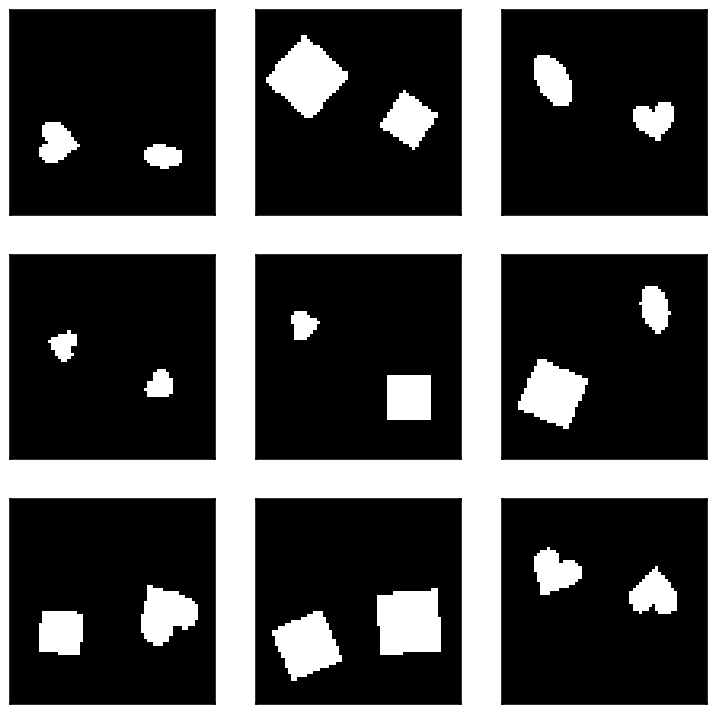

In [ ]:
image_fused = np.clip(imgs_sampled_dx - imgs_sampled_sx, a_max=1, a_min=0)
y_fused = np.clip((latents_sampled_dx[:, 1] == 0) + (latents_sampled_sx[:, 1] == 2), a_max=1, a_min=0)
c_fused =  np.clip(c_sx + c_dx, a_max=1, a_min=0)
c_fused[:, 3] = 1
show_images_grid(image_fused, 9)

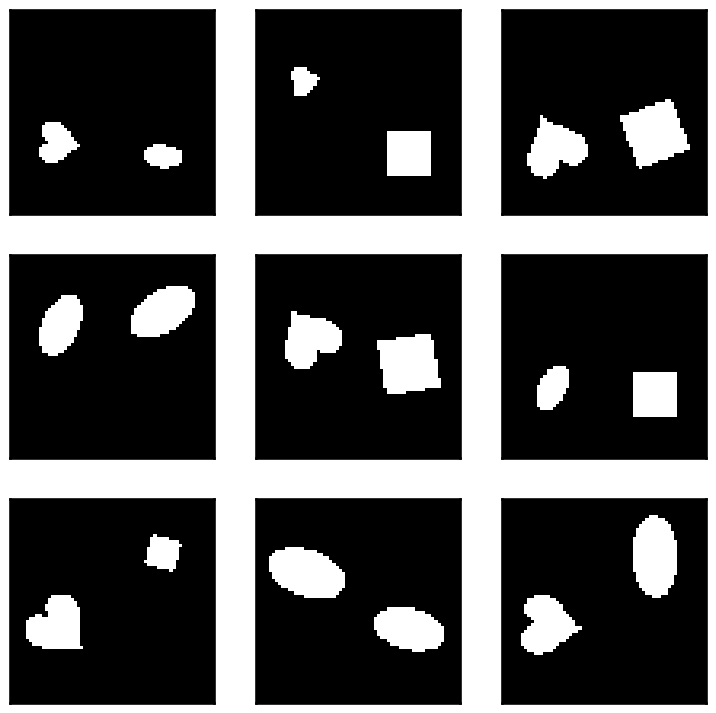

In [ ]:
no_sq_no_heart = image_fused[((latents_sampled_sx[:, 1] != 0).astype(float) * (latents_sampled_dx[:, 1] != 2).astype(float)).astype(bool), :, :]
y_no_sq_no_heart = y_fused[((latents_sampled_sx[:, 1] != 0).astype(float) * (latents_sampled_dx[:, 1] != 2).astype(float)).astype(bool)]
c_no_sq_no_heart = c_fused[((latents_sampled_sx[:, 1] != 0).astype(float) * (latents_sampled_dx[:, 1] != 2).astype(float)).astype(bool)]
show_images_grid(no_sq_no_heart, 9)

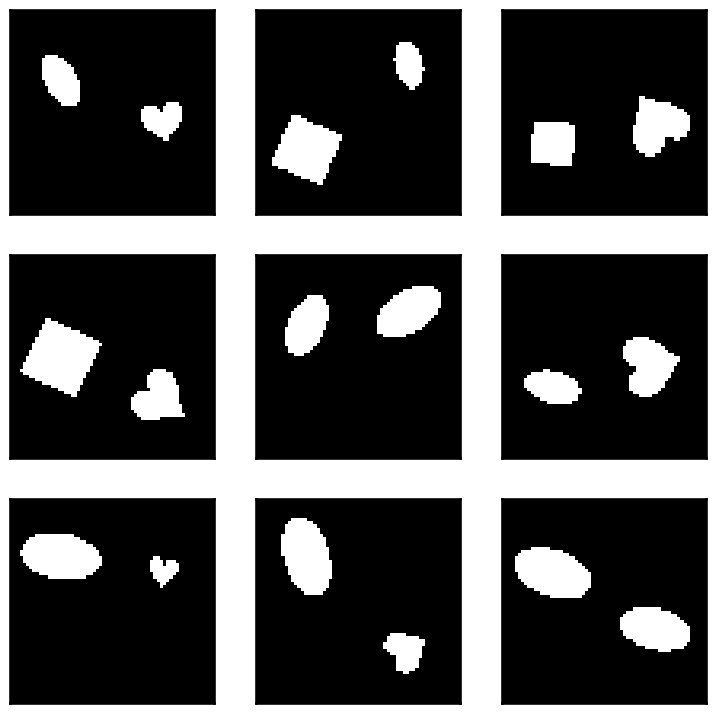

In [ ]:
no_heart_no_sq = image_fused[((latents_sampled_sx[:, 1] != 2).astype(float) * (latents_sampled_dx[:, 1] != 0).astype(float)).astype(bool), :, :]
y_no_heart_no_sq = y_fused[((latents_sampled_sx[:, 1] != 2).astype(float) * (latents_sampled_dx[:, 1] != 0).astype(float)).astype(bool)]
c_no_heart_no_sq = c_fused[((latents_sampled_sx[:, 1] != 2).astype(float) * (latents_sampled_dx[:, 1] != 0).astype(float)).astype(bool)]
show_images_grid(no_heart_no_sq, 9)


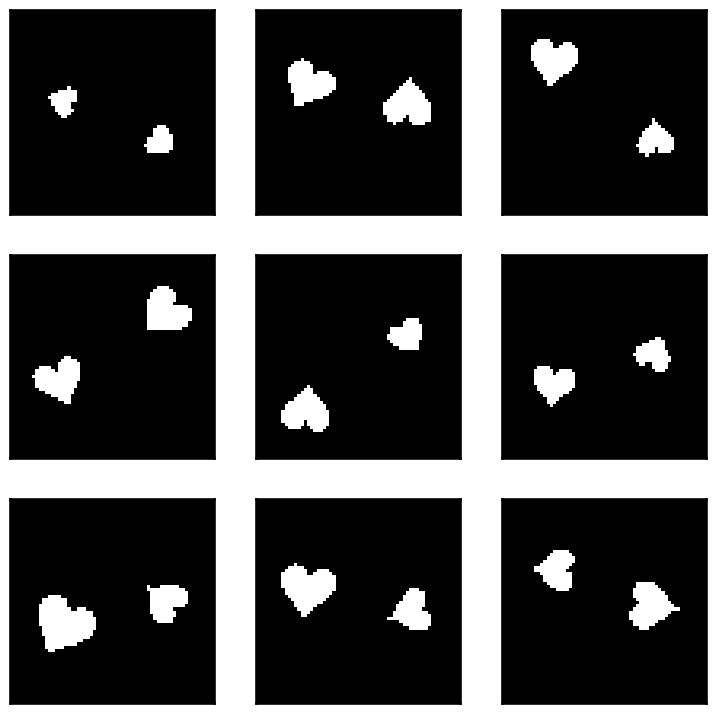

In [ ]:
hh = image_fused[((latents_sampled_sx[:, 1] == 2).astype(float) * (latents_sampled_dx[:, 1] == 2).astype(float)).astype(bool), :, :]
y_hh = np.ones(len(hh))
c_hh = c_fused[((latents_sampled_sx[:, 1] == 2).astype(float) * (latents_sampled_dx[:, 1] == 2).astype(float)).astype(bool)]
show_images_grid(hh, 9)

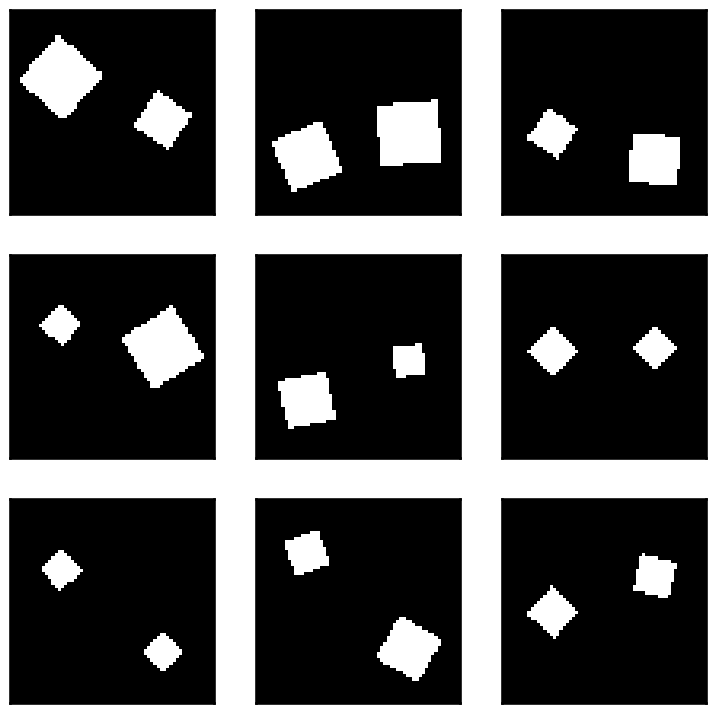

In [ ]:
sqsq = image_fused[((latents_sampled_sx[:, 1] == 0).astype(float) * (latents_sampled_dx[:, 1] == 0).astype(float)).astype(bool), :, :]
y_sqsq = np.ones(len(sqsq))
c_sqsq = c_fused[((latents_sampled_sx[:, 1] == 0).astype(float) * (latents_sampled_dx[:, 1] == 0).astype(float)).astype(bool)]
show_images_grid(sqsq, 9)

In [3]:
print(len(imgs_sampled_dx), len(y_dx), len(c_dx), len(imgs_sampled_sx), len(y_sx), len(c_sx))

NameError: name 'imgs_sampled_dx' is not defined

In [206]:
print(len(no_sq_no_heart), len(y_no_sq_no_heart), len(c_no_sq_no_heart), len(no_heart_no_sq), len(y_no_heart_no_sq), len(c_no_heart_no_sq))

1363 1363 1363 1317 1317 1317


In [207]:
print(len(hh), len(y_hh), len(c_hh), len(sqsq), len(y_sqsq), len(c_sqsq))

353 353 353 316 316 316


In [208]:
train_set_imgs = np.concatenate([imgs_sampled_dx[:int(len(imgs_sampled_dx)*0.8)], 
                                    imgs_sampled_sx[:int(len(imgs_sampled_sx)*0.8)], 
                                    no_sq_no_heart[:int(len(no_sq_no_heart)*0.8)], 
                                    no_heart_no_sq[:int(len(no_heart_no_sq)*0.8)], 
                                    hh[:int(len(no_heart_no_sq)*0.8)]], axis=0)
y_train = np.concatenate([y_dx[:int(len(imgs_sampled_dx)*0.8)],
                            y_sx[:int(len(imgs_sampled_sx)*0.8)],
                            y_no_sq_no_heart[:int(len(no_sq_no_heart)*0.8)],
                            y_no_heart_no_sq[:int(len(no_heart_no_sq)*0.8)],
                            y_hh[:int(len(no_heart_no_sq)*0.8)]], axis=0)
c_train = np.concatenate([c_dx[:int(len(imgs_sampled_dx)*0.8)],
                            c_sx[:int(len(imgs_sampled_sx)*0.8)],
                            c_no_sq_no_heart[:int(len(no_sq_no_heart)*0.8)],
                            c_no_heart_no_sq[:int(len(no_heart_no_sq)*0.8)],
                            c_hh[:int(len(no_heart_no_sq)*0.8)]], axis=0)

In [209]:
test_set_imgs = np.concatenate([imgs_sampled_dx[int(len(imgs_sampled_dx)*0.8):],
                                    imgs_sampled_sx[int(len(imgs_sampled_sx)*0.8):],
                                    no_sq_no_heart[int(len(no_sq_no_heart)*0.8):],
                                    no_heart_no_sq[int(len(no_heart_no_sq)*0.8):],
                                    hh[int(len(no_heart_no_sq)*0.8):],
                                    sqsq], axis=0)
y_test = np.concatenate([y_dx[int(len(imgs_sampled_dx)*0.8):],
                            y_sx[int(len(imgs_sampled_sx)*0.8):],
                            y_no_sq_no_heart[int(len(no_sq_no_heart)*0.8):],
                            y_no_heart_no_sq[int(len(no_heart_no_sq)*0.8):],
                            y_hh[int(len(no_heart_no_sq)*0.8):],
                            y_sqsq], axis=0)
c_test = np.concatenate([c_dx[int(len(imgs_sampled_dx)*0.8):],
                            c_sx[int(len(imgs_sampled_sx)*0.8):],
                            c_no_sq_no_heart[int(len(no_sq_no_heart)*0.8):],
                            c_no_heart_no_sq[int(len(no_heart_no_sq)*0.8):],
                            c_hh[int(len(no_heart_no_sq)*0.8):],
                            c_sqsq], axis=0)

In [210]:
import os
save_dir = './datasets/dsprites'
os.makedirs(save_dir, exist_ok=True)

train_images_file = os.path.join(save_dir, 'train_images.npy')
test_images_file = os.path.join(save_dir, 'test_images.npy')
train_labels_file = os.path.join(save_dir, 'train_labels.npy')
test_labels_file = os.path.join(save_dir, 'test_labels.npy')
train_concepts_file = os.path.join(save_dir, 'train_concepts.npy')
test_concepts_file = os.path.join(save_dir, 'test_concepts.npy')

np.save(train_images_file, train_set_imgs)
np.save(test_images_file, test_set_imgs)
np.save(train_labels_file, y_train)
np.save(test_labels_file, y_test)
np.save(train_concepts_file, c_train)
np.save(test_concepts_file, c_test)